# Learning Functions

Implementation of the simple function learning experiment carried out in section 4.1 of [*Neural Arithmetic Logic Units*](https://arxiv.org/abs/1808.00508).

Functions learned:

* Addition
* Subtraction
* Multiplication
* Division
* Sqrt
* Square

In [17]:
# Load environment
using Pkg
Pkg.activate("..")

"/Users/domluna/github/NeuralArithmetic/Project.toml"

In [18]:
using NeuralArithmetic
using Flux
using Plots
using DataFrames

In [19]:
# number of training set examples
N = 500

500

The dataset of a function will contain `N` training examples, 100 validation examples (interpolation), and 100 testing examples (extrapolation).

The examples are sampled for a uniform distribution and then scaled to a larger range, the extrapolation range is larger than the interpolation range.

In [20]:
struct Dataset{F}
    f::F
    input_dim::Int
    train
    val # interpolation data
    test # extrapolation data
end

function gen_data_binary(f::F, n::Int, irange=5.0, erange=20.0) where {F}
    X = [rand(n+100)*irange rand(n+100)*irange]'
    y = f.(X[1, :], X[2, :])
    train = (X[:, 1:n], y[1:n])
    val = (X[:, n+1:end], y[n+1:end])
    testX = [rand(100)*erange rand(100)*erange]'
    testy = f.(testX[1, :], testX[2, :])
    test = (testX, testy)
    return Dataset(f, 2, train, val, test)
end

function gen_data_unary(f::F, n::Int, irange=5.0, erange=20.0) where {F}
    X = reshape(rand(n+100)*irange, (1, :))
    y = f.(X[1, :])
    train = (X[:, 1:n], y[1:n])
    val = (X[:, n+1:end], y[n+1:end])
    testX = reshape(rand(100)*erange, (1, :))
    testy = f.(testX[1, :])
    test = (testX, testy)
    return Dataset(f, 1, train, val, test)
end



gen_data_unary (generic function with 3 methods)

In [21]:
square = (x) -> ^(x, 2)

add_data = gen_data_binary(+, N)
sub_data = gen_data_binary(-, N)
div_data = gen_data_binary(/, N)
mul_data = gen_data_binary(*, N)
sqrt_data = gen_data_unary(sqrt, N)
square_data = gen_data_unary(square, N)

datasets = Dict(
    "add" => add_data,
    "sub" => sub_data,
    "div" => div_data,
    "mul" => mul_data,
    "sqrt" => sqrt_data,
    "square" => square_data,
)

Dict{String,Dataset} with 6 entries:
  "add"    => Dataset{typeof(+)}(+, 2, ([0.492049 0.284978 … 4.64566 2.18935; 4…
  "sub"    => Dataset{typeof(-)}(-, 2, ([0.15217 4.42768 … 0.268623 2.15319; 0.…
  "div"    => Dataset{typeof(/)}(/, 2, ([0.678176 2.82889 … 0.52684 1.19003; 2.…
  "mul"    => Dataset{typeof(*)}(*, 2, ([0.0684826 0.936397 … 2.40829 4.3193; 1…
  "sqrt"   => Dataset{typeof(sqrt)}(sqrt, 1, ([1.33601 3.34401 … 2.71447 1.1343…
  "square" => Dataset{##103#104}(##103#104(), 1, ([2.92571 3.35081 … 3.29686 2.…

Models we'll use in the experiments:

In [31]:
relu6(x) = min.(max.(x, 0.0), 6.0)

linear_model = (input_dim) -> Chain(Dense(input_dim, 2), Dense(2, 1))
relu6_model = (input_dim) -> Chain(Dense(input_dim, 2, relu6), Dense(2, 1))
nac_model = (input_dim) -> Chain(NAC(input_dim, 2), Dense(2, 1))
nalu_model = (input_dim) -> Chain(NALU(input_dim, 2), Dense(2, 1))

#177 (generic function with 1 method)

`train_model` trains the model are records interpolation and extrapolation losses.

`run_experiment` trains a separate model for each dataset and accumulates the results in `DataFrame`s.

In [37]:
loss(m) = (x, y) -> Flux.mse(m(x), y')

function train_model(model, opt, ds::Dataset, epochs::Int, print_interval::Int)
    lossf = loss(model)
    hist = Array{Float64}(undef, 2, epochs)
    for i in 1:epochs
        Flux.train!(lossf, [ds.train], opt)
        val_loss = Flux.data(lossf(ds.val...))
        test_loss = Flux.data(lossf(ds.test...))
        if print_interval != -1 && i % print_interval == 0
            @info "Iteration $i, validation loss = $val_loss"
        end
        hist[1, i] = val_loss
        hist[2, i] = test_loss
    end
    return hist
end

function run_experiment(modelf, datasets::Dict{String, Dataset}, epochs::Int=1000, print_interval::Int=-1)
    interpolation_df = DataFrame()
    extrapolation_df = DataFrame()
    for (name, ds) in datasets
        m = modelf(ds.input_dim)
        opt = ADAM(params(m), 1e-2)
        hist = train_model(m, opt, ds, epochs, print_interval)
        interpolation_df[Symbol(name)] = hist[1, :]
        extrapolation_df[Symbol(name)] = hist[2, :]
        @info "Done evaluation dataset $name"
    end
    return interpolation_df, extrapolation_df
end

run_experiment (generic function with 3 methods)

Let's run the experiments and plot results.

In [38]:
epochs = 10_000
# print_interval = 100

10000

┌ Info: Done evaluation dataset add
└ @ Main In[37]:28
┌ Info: Done evaluation dataset sub
└ @ Main In[37]:28
┌ Info: Done evaluation dataset div
└ @ Main In[37]:28
┌ Info: Done evaluation dataset mul
└ @ Main In[37]:28
┌ Info: Done evaluation dataset sqrt
└ @ Main In[37]:28
┌ Info: Done evaluation dataset square
└ @ Main In[37]:28
┌ Info: Interpolation final losses: Tuple{Symbol,Float64}[(:add, 5.52203e-31), (:sub, 2.34358e-31), (:div, 23.5431), (:mul, 4.31753), (:sqrt, 0.00632299), (:square, 3.53013)]
└ @ Main In[39]:3
┌ Info: Extrapolation final losses: Tuple{Symbol,Float64}[(:add, 7.86692e-30), (:sub, 3.35821e-30), (:div, 14039.7), (:mul, 10531.8), (:sqrt, 2.90488), (:square, 15112.1)]
└ @ Main In[39]:10


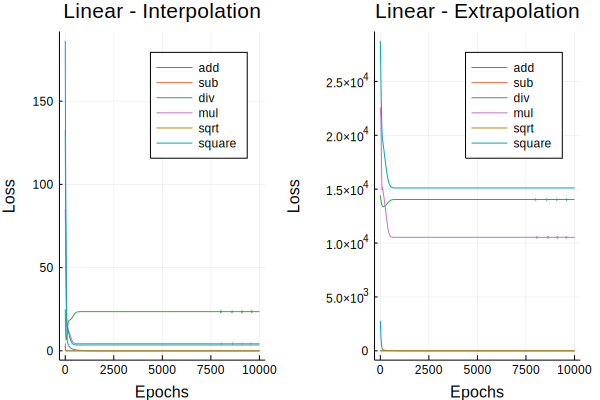

In [39]:
df1, df2 = run_experiment(linear_model, datasets, epochs)

@info "Interpolation final losses: $([(name, df1[name][end]) for name in names(df1)])"
p1 = plot(1:epochs, [df1[name] for name in names(df1)], 
    title="Linear - Interpolation",
    xlabel="Epochs",
    ylabel="Loss",
    labels=[String.(name) for name in names(df1)])

@info "Extrapolation final losses: $([(name, df2[name][end]) for name in names(df2)])"
p2 = plot(1:epochs, [df2[name] for name in names(df2)], 
    title="Linear - Extrapolation",
    xlabel="Epochs",
    ylabel="Loss",
    labels=[String.(name) for name in names(df2)])

plot(p1, p2)

ReLU6 model.

┌ Info: Done evaluation dataset add
└ @ Main In[37]:28
┌ Info: Done evaluation dataset sub
└ @ Main In[37]:28
┌ Info: Done evaluation dataset div
└ @ Main In[37]:28
┌ Info: Done evaluation dataset mul
└ @ Main In[37]:28
┌ Info: Done evaluation dataset sqrt
└ @ Main In[37]:28
┌ Info: Done evaluation dataset square
└ @ Main In[37]:28
┌ Info: Interpolation final losses: Tuple{Symbol,Float64}[(:add, 4.72373), (:sub, 4.47398), (:div, 7.02741), (:mul, 1.40584), (:sqrt, 0.0062948), (:square, 66.4886)]
└ @ Main In[40]:3
┌ Info: Extrapolation final losses: Tuple{Symbol,Float64}[(:add, 292.477), (:sub, 64.6547), (:div, 4950.31), (:mul, 15231.2), (:sqrt, 0.690116), (:square, 28106.4)]
└ @ Main In[40]:10


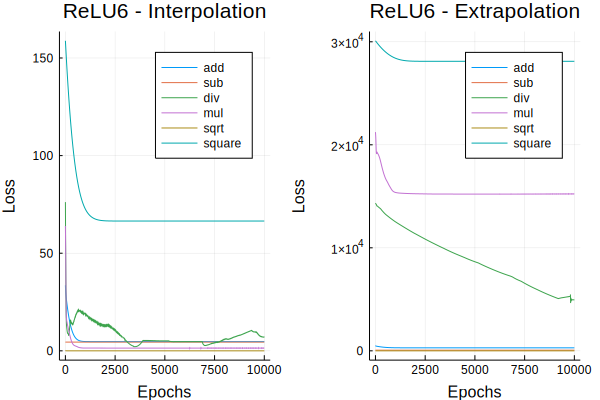

In [40]:
df1, df2 = run_experiment(relu6_model, datasets, epochs)

@info "Interpolation final losses: $([(name, df1[name][end]) for name in names(df1)])"
p1 = plot(1:epochs, [df1[name] for name in names(df1)], 
    title="ReLU6 - Interpolation",
    xlabel="Epochs",
    ylabel="Loss",
    labels=[String.(name) for name in names(df1)])

@info "Extrapolation final losses: $([(name, df2[name][end]) for name in names(df2)])"
p2 = plot(1:epochs, [df2[name] for name in names(df2)], 
    title="ReLU6 - Extrapolation",
    xlabel="Epochs",
    ylabel="Loss",
    labels=[String.(name) for name in names(df2)])

plot(p1, p2)

NAC model.

┌ Info: Done evaluation dataset add
└ @ Main In[37]:28
┌ Info: Done evaluation dataset sub
└ @ Main In[37]:28
┌ Info: Done evaluation dataset div
└ @ Main In[37]:28
┌ Info: Done evaluation dataset mul
└ @ Main In[37]:28
┌ Info: Done evaluation dataset sqrt
└ @ Main In[37]:28
┌ Info: Done evaluation dataset square
└ @ Main In[37]:28
┌ Info: Interpolation final losses: Tuple{Symbol,Float64}[(:add, 9.59711e-30), (:sub, 2.31213e-5), (:div, 23.543), (:mul, 4.31867), (:sqrt, 0.00632194), (:square, 3.53013)]
└ @ Main In[41]:3
┌ Info: Extrapolation final losses: Tuple{Symbol,Float64}[(:add, 1.36822e-28), (:sub, 0.000269146), (:div, 14039.7), (:mul, 10533.2), (:sqrt, 2.90592), (:square, 15112.1)]
└ @ Main In[41]:10


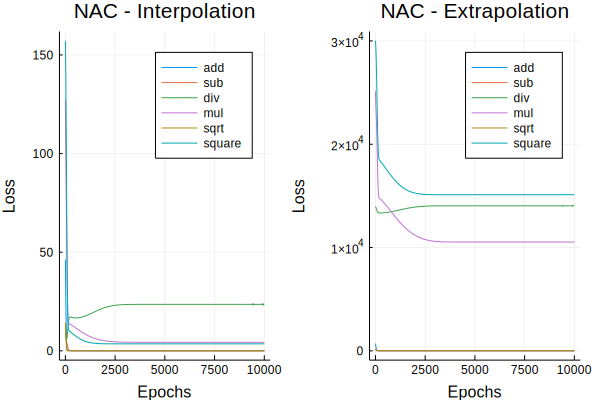

In [41]:
df1, df2 = run_experiment(nac_model, datasets, epochs)

@info "Interpolation final losses: $([(name, df1[name][end]) for name in names(df1)])"
p1 = plot(1:epochs, [df1[name] for name in names(df1)], 
    title="NAC - Interpolation",
    xlabel="Epochs",
    ylabel="Loss",
    labels=[String.(name) for name in names(df1)])

@info "Extrapolation final losses: $([(name, df2[name][end]) for name in names(df2)])"
p2 = plot(1:epochs, [df2[name] for name in names(df2)], 
    title="NAC - Extrapolation",
    xlabel="Epochs",
    ylabel="Loss",
    labels=[String.(name) for name in names(df2)])

plot(p1, p2)

NALU model.

┌ Info: Done evaluation dataset add
└ @ Main In[37]:28
┌ Info: Done evaluation dataset sub
└ @ Main In[37]:28
┌ Info: Done evaluation dataset div
└ @ Main In[37]:28
┌ Info: Done evaluation dataset mul
└ @ Main In[37]:28
┌ Info: Done evaluation dataset sqrt
└ @ Main In[37]:28
┌ Info: Done evaluation dataset square
└ @ Main In[37]:28
┌ Info: Interpolation final losses: Tuple{Symbol,Float64}[(:add, 1.67385e-5), (:sub, 4.41529e-7), (:div, 0.00349782), (:mul, 0.00149062), (:sqrt, 9.54571e-6), (:square, 0.136825)]
└ @ Main In[42]:3
┌ Info: Extrapolation final losses: Tuple{Symbol,Float64}[(:add, 0.0228284), (:sub, 2.93072e-7), (:div, 550.534), (:mul, 198.686), (:sqrt, 0.000700885), (:square, 10261.6)]
└ @ Main In[42]:10


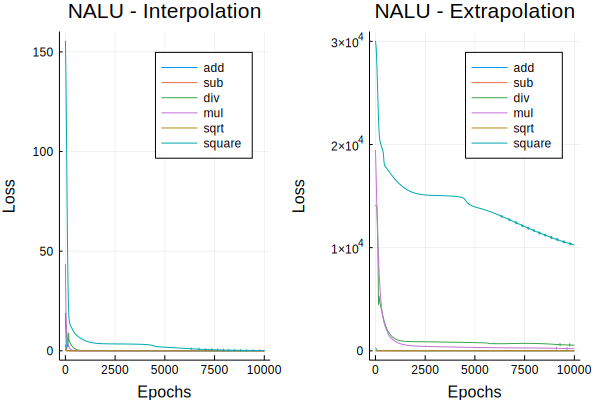

In [42]:
df1, df2 = run_experiment(nalu_model, datasets, epochs)

@info "Interpolation final losses: $([(name, df1[name][end]) for name in names(df1)])"
p1 = plot(1:epochs, [df1[name] for name in names(df1)], 
    title="NALU - Interpolation",
    xlabel="Epochs",
    ylabel="Loss",
    labels=[String.(name) for name in names(df1)])

@info "Extrapolation final losses: $([(name, df2[name][end]) for name in names(df2)])"
p2 = plot(1:epochs, [df2[name] for name in names(df2)], 
    title="NALU - Extrapolation",
    xlabel="Epochs",
    ylabel="Loss",
    labels=[String.(name) for name in names(df2)])

plot(p1, p2)